In [1]:
#!/usr/bin/env python
# coding: utf-8

In[121]:

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2023-06-30 22:20:37.097846: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 22:20:37.237643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 22:20:37.484802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 22:20:37.485657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 22:20:38.824547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Load the data

In[122]:

In [3]:
!mkdir data && wget https://github.com/sdip15fa/weather-predict/raw/master/data/processed_data.csv -O data/processed_data.csv

input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
df = df[(df['Temperature'] >= df['Temperature'].quantile(0.02)) &
        (df['Temperature'] <= df['Temperature'].quantile(0.98))]
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

mkdir: cannot create directory ‘data’: File exists


Rename the columns for better readability

In[123]:

df.columns = ['DateTime', 'Year', 'Month', 'Date', 'Time', 'Minute', 'Temperature', 'Previous Day Average', 'Two Days Before Average',<br>
'Three Days Before average', 'Last 7 Days Average', 'Previous Day Wind Speed', 'Previous Day Rainfall']

Convert the 'Date' and 'Time' columns to integers

In[124]:

In [4]:
df['Date'] = df['Date'].astype(int)
df['Time'] = df['Time'].astype(int)

Fill leading zeros for the 'Time' column

In[125]:

In [5]:
df['Time'] = df['Time'].apply(lambda x: str(x).zfill(4))

Combine the 'Date' and 'Time' columns into a single 'DateTime' column

In[126]:

df['DateTime'] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")

In[ ]:

Remove rows with a specific value (e.g., 32767) in 'Temperature' column

In[127]:

In [6]:
df = df[df['Temperature'] != 32767]

Calculate the mean and standard deviation of Y

In[128]:

In [7]:
threshold = 5
mean_Y = np.mean(df['Temperature'])
std_Y = np.std(df['Temperature'])

Define the range of acceptable Y values

In[129]:

In [8]:
lower_bound = mean_Y - threshold * std_Y
upper_bound = mean_Y + threshold * std_Y

Filter out rows with Y values outside the acceptable range

In[130]:

In [9]:
df = df[(df['Temperature'] >= lower_bound) &
        (df['Temperature'] <= upper_bound)]

Prepare the data for LSTM

In[131]:

In [10]:
time_steps = 72  # Number of time steps for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

Create sequences of input data and corresponding target values

In[133]:

Filter out the outliers and invalid values for the new features<br>
Replace the specific invalid values (e.g., 32767) with np.nan

In [11]:
df['Wind Speed'] = df['Wind Speed'].replace(32767, np.nan)
df['Rainfall'] = df['Rainfall'].replace(32767, np.nan)
df['Wind Direction'] = df['Wind Direction'].replace(32767, np.nan)
df = df[(df['Wind Direction'] >= 0) & (df['Wind Direction'] <= 360)]
df = df[(df['Wind Speed'] <= df['Wind Speed'].quantile(0.99))]
df = df[(df['Rainfall'] <= df['Rainfall'].quantile(0.99))]


Remove rows with missing values

In [12]:
df = df.dropna()

In [13]:
df

,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall
0,2008-01-01 12:00:00,2008.0,1.0,1,0012,1.0,5.1,44.0,39.0,0.0
1,2008-01-01 13:00:00,2008.0,1.0,1,0013,1.0,5.8,31.0,49.0,0.0
2,2008-01-01 14:00:00,2008.0,1.0,1,0014,1.0,6.6,32.0,36.0,0.0
3,2008-01-01 15:00:00,2008.0,1.0,1,0015,1.0,7.2,37.0,33.0,0.0
4,2008-01-01 16:00:00,2008.0,1.0,1,0016,1.0,6.7,60.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...
119719,2023-06-30 15:00:00,2023.0,6.0,30,0015,1.0,23.8,50.0,222.0,0.0
119720,2023-06-30 16:00:00,2023.0,6.0,30,0016,1.0,24.4,44.0,216.0,0.0
119721,2023-06-30 17:00:00,2023.0,6.0,30,0017,1.0,23.4,32.0,201.0,0.0
119722,2023-06-30 18:00:00,2023.0,6.0,30,0018,1.0,23.0,27.0,194.0,0.0


In [14]:
features_keys = ['Temperature', 'Wind Speed',
               'Rainfall']

Scale the temperature, wind speed, rainfall, and wind direction values

In [15]:
features = df[features_keys].copy()
scaled_features = scaler.fit_transform(features)

In [16]:
scaled_features

array([[0.        , 0.24571429, 0.        ],
       [0.03414634, 0.17142857, 0.        ],
       [0.07317073, 0.17714286, 0.        ],
       ...,
       [0.89268293, 0.17714286, 0.        ],
       [0.87317073, 0.14857143, 0.        ],
       [0.86341463, 0.22857143, 0.        ]])

Create sequences of input data and corresponding target values

In [17]:
data = []
target = []
for i in range(1, len(scaled_features) - time_steps):
    # exclude the target
    data.append(scaled_features[i:i+time_steps])
    # Only the temperature is the target
    target.append(scaled_features[i+time_steps])

In [18]:
data = np.array(data)
target = np.array(target)


In[135]:

Define exclude date (year, month, and day)

In[136]:

Split the dataset into training and validation sets

In[137]:

In [19]:
split = 0.1
exclude_index = int(len(data) * (1-split))
train_data, train_target = data[:exclude_index], target[:exclude_index]
val_data, val_target = data[exclude_index:], target[exclude_index:]


Build the LSTM model architecture

In[138]:

In [20]:
import tensorflow as tf
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True,
                         input_shape=(time_steps, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
"""
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(time_steps, len(features_keys))),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dense(64),
    # tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(features_keys))
])


2023-06-30 22:20:41.541845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1579] failed to query PCI bus id for device: UNKNOWN ERROR (801)
2023-06-30 22:20:41.542065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:970] no PCI bus ID for device ordinal: 0
2023-06-30 22:20:41.543812: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-30 22:20:41.905371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' wi

Compile the model

In[139]:

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

Define early stopping and learning rate scheduler

In[140]:

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Train the LSTM model

In[141]:

In [23]:
batch_size = 4096
epochs = 100
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


2023-06-30 22:20:42.814812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 22:20:42.815980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 22:20:42.817295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyboardInterrupt: 

Make predictions using the trained LSTM model

In[142]:

In [ ]:
predictions = model.predict(val_data)

Rescale the predictions back to the original range

In[143]:

In [ ]:
scaled_predictions = pd.DataFrame(predictions, columns=features_keys)
predictions = pd.DataFrame(scaler.inverse_transform(
    predictions), columns=features_keys)
predicted_temperature = predictions["Temperature"]


In [ ]:
val_target = pd.DataFrame(val_target, columns=features_keys)
val_target_rescaled = pd.DataFrame(scaler.inverse_transform(val_target), columns=features_keys)
train_target = pd.DataFrame(train_target, columns=features_keys)
train_target_rescaled = pd.DataFrame(scaler.inverse_transform(train_target), columns=features_keys)

Calculate MSE and MAE

In[144]:

In [ ]:
mse = mean_squared_error(val_target_rescaled["Temperature"], predictions["Temperature"])
mae = mean_absolute_error(val_target_rescaled["Temperature"], predictions["Temperature"])

In[145]:

In [ ]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Visualize the actual vs. predicted temperatures for the validation set

In[146]:

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), val_target_rescaled["Temperature"], label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Visualize the actual vs. predicted temperatures for the training set

In[147]:

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_target)), train_target["Temperature"], label='Actual')
plt.plot(range(len(train_target)), pd.DataFrame(model.predict(
    train_data), columns=features_keys)["Temperature"], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Training Set)')
plt.legend()
plt.show()

Save the trained model

In[148]:

In [ ]:
model.save("lstm.keras")

In [ ]:
scaled_features
scaled_features.copy()[-time_steps:].shape

In [24]:
model = tf.keras.models.load_model("lstm.keras")

data = scaled_features.copy()[-time_steps:]
predicted = []

for i in range(1, 31):
    scaled_prediction = model.predict(data.reshape(1, time_steps, len(features_keys)))
    prediction = scaler.inverse_transform(scaled_prediction)[0]
    print(f"{i} hour(s) prediction:", list(map(lambda x: round(x, 6),prediction)))
    # print(prediction[0], data, np.append(data, prediction[0]))
    data = np.vstack((data, scaled_prediction))
    data = np.delete(data, 0, axis=0)
    predicted.append(prediction)

2023-06-30 22:21:28.045324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 22:21:28.048721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 22:21:28.050287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
1 hour(s) prediction: [22.38149, 44.7513, 0.000441]
1/1 [==============================] - 0s 24ms/step
2 hour(s) prediction: [22.203348, 50.877117, 0.001602]
1/1 [==============================] - 0s 24ms/step
3 hour(s) prediction: [22.058475, 55.765823, -0.002109]
1/1 [==============================] - 0s 26ms/step
4 hour(s) prediction: [21.978458, 59.27918, -0.003957]
1/1 [==============================] - 0s 23ms/step
5 hour(s) prediction: [21.924747, 61.487686, -0.004227]
1/1 [==============================] - 0s 25ms/step
6 hour(s) prediction: [21.876413, 62.571014, -0.003368]
1/1 [==============================] - 0s 28ms/step
7 hour(s) prediction: [21.839142, 62.75413, -0.001682]
1/1 [==============================] - 0s 24ms/step
8 hour(s) prediction: [21.833576, 62.21646, 0.000306]
1/1 [==============================] - 0s 19ms/step
9 hour(s) prediction: [21.881483, 61.067997, 0.002058]
1/1 [==============================] - 0

In [25]:
results = pd.DataFrame(predicted, columns=features_keys)
results.to_csv("predict.csv")

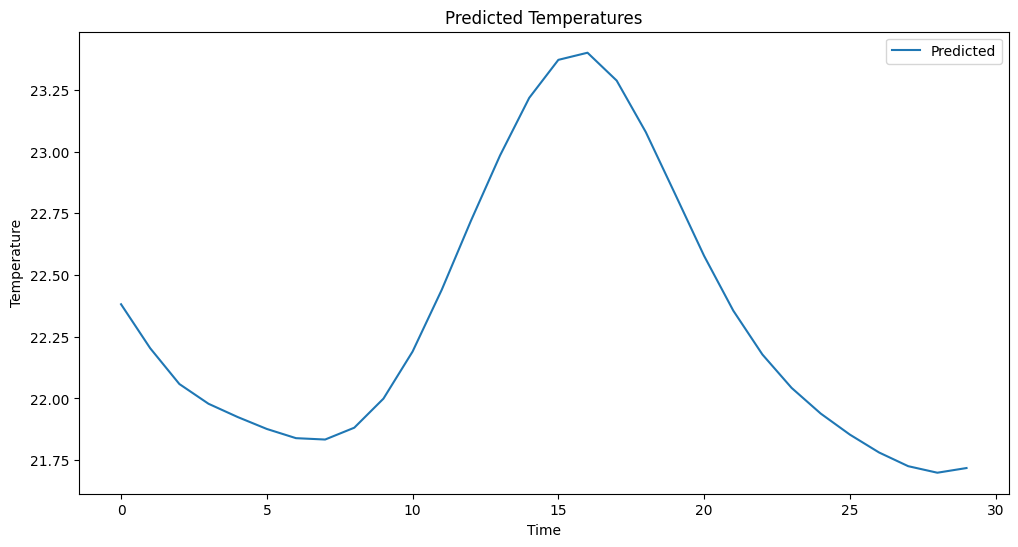

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(range(30), np.array(predicted)[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()